# Find A Raster Tile

**Goal**: Find the 3DEP DEM raster tile your pit falls in.

**Approach**: 
1. Grab the pit location from the site data table in the database
2. Perform an intersect on all raster tiles with the pit location 
3. Plot it!


### Step 1. Grab the pit location from the Site Data

In [6]:
#Import our typical DB access function 
from snowexsql.db import get_db

# Import our ORM table classes that were going to use
from snowexsql.data import ImageData, SiteData

# Rasterio plot function is convenient
from rasterio.plot import show
import matplotlib.pyplot as plt 

# To access general SQL functions
from sqlalchemy.sql import func

# Convert WKB to pyshape
from geoalchemy2.shape import to_shape

# Builds geodataframes!
import geopandas as gpd

# Import a useful function from snowexsql to convert incoming data from the db to rasterio dataset objects
from snowexsql.conversions import raster_to_rasterio

In [7]:
# PIT Site Identifier
site_id = '5S31'

# Connect to the database
db_name = 'snow:hackweek@52.32.183.144/snowex'
engine, session = get_db(db_name)

# Grab our pit location by the site ID
q = session.query(SiteData).filter(SiteData.site_id == site_id)
sites = q.all()

# Grab the pit location from a single layer
p = sites[0].geom

### Step 2. Perform an intersect on all raster tiles with the pit location 

In [8]:
# Raster Data is stored in Binary. So we use the POSTGIS function to return a a geotiff https://postgis.net/docs/RT_ST_AsTIFF.html
q = session.query(func.ST_AsTiff(ImageData.raster))

# Filter images that contain the word in 3DEP in their description 
q = q.filter(ImageData.description.contains('3DEP'))

# Filter rasters by where a tile intersects with the pit location using POSTGIS function ST_Intersects https://postgis.net/docs/RT_ST_Intersects.html
rasters = q.filter(func.ST_Intersects(ImageData.raster, p)).all()

# Convert it to a rasterio dataset for easy plotting
dataset = raster_to_rasterio(session, rasters)[0]


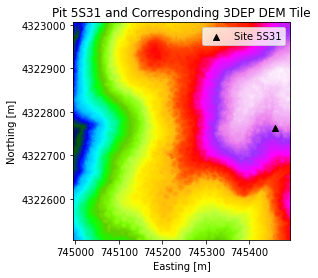

In [9]:
fig,ax = plt.subplots()

# Plot the rasterio dataset
show(dataset.read(1), ax=ax, transform=dataset.transform, cmap='gist_ncar')

# Add to our plot the pit location
p_shp = to_shape(p)
gpd.GeoSeries(p_shp).plot(ax=ax, color='k', marker='^', label="Site {}".format(site_id))

# Add some labeling
ax.ticklabel_format(style='plain', useOffset=False)
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_title('Pit {} and Corresponding 3DEP DEM Tile'.format(site_id))
a = ax.legend()

In [11]:
# Close all our datasets held in memory
dataset.close()

# Close the session to avoid hanging transactions
session.close()